In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt

In [2]:
import sys
sys.path.append('/home/digarza/cholla_dev/cholla-viz')

In [3]:
from ChollaSnap import *
from ChollaRun import *

In [4]:
plt.style.use("dstyle")
_ = plt.figure()
plt.style.use("dstyle")

<Figure size 432x288 with 0 Axes>

In [5]:
##############
def calc_velocity(data):
    data["vel_x"] = data["momentum_x"] / data["density"]
    data["vel_y"] = data["momentum_y"] / data["density"]
    data["vel_z"] = data["momentum_z"] / data["density"]
    data["vel_mag"] = np.sqrt(data["vel_x"]**2 + data["vel_y"]**2 + data["vel_z"]**2)

def req_velocity(data, head):
    return ["momentum_x", "momentum_y", "momentum_z", "density"]

kwarg_fn = None

velocity_calc = ChollaValueCalc(calc_velocity, req_velocity, kwarg_fn)

##############
def calc_press(data, DE=None, gamma=None):
    if DE:
        data["pressure"] = data["Energy"]*(gamma-1.0)
    else:
        data["pressure"] = (data["Energy"] - 0.5*data["density"]*(data["vel_mag"]**2)) * (gamma - 1.0)

def req_press(data, head):
    return ["vel_mag", "Energy", "density"]

def kwargs_press(kwargs, data, head):
    kwargs["gamma"] = head["gamma"]
    kwargs["DE"] = None

press_calc = ChollaValueCalc(calc_press, req_press, kwargs_press)


##############
def calc_intenergy(data, DE=None, gamma=None):
    
    if DE:
        data["int_energy"] = data["Energy"]/data["density"]
    else:
        data["int_energy"] = data["pressure"]/data["density"]/(gamma - 1.0)

def req_intenergy(data, head):
    DE = 0
    if DE:
        return ["density", "Energy"]
    else:
        return ["pressure", "density", "Energy"]

def kwargs_intenergy(kwargs, data, head):
    kwargs["gamma"] = head["gamma"]
    kwargs["DE"] = None

intenergy_calc = ChollaValueCalc(calc_intenergy, req_intenergy, kwargs_intenergy)


##############
cholla_calcs = [velocity_calc, press_calc, intenergy_calc]

In [77]:
tot_nsnap = 11
nblock = 4
base_dir =  "/data/users/digarza/cholla_exs/2D_Test/Rayleigh_Taylor"
namebase = "h5"
img_dir = "/imgs/density" # where to store images relative to base_dir

ch_run = ChollaRun(base_dir, tot_nsnap, namebase, nblock, img_dir=img_dir)

In [78]:
def plot_density_2D(data, head, plt_kwargs):
    from mpl_toolkits.axes_grid1 import make_axes_locatable

    density = data["density"][:,:,0].T
    time = head["t"][0]
    time_str = f"t = {time:.3f}"
    
    fig, ax = plt.subplots(nrows=1, ncols=1)

    im = ax.imshow(density)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)

    fig.colorbar(im, cax=cax, orientation='vertical', format='%.3f')

    ax.set_xlim(0, head["dims"][0] - 1)
    ax.set_ylim(0, head["dims"][1] - 1)
    
    # ax.text(200, 260, time_str, fontsize=28)

    ax.set_xlabel("X (cells)")
    ax.set_ylabel("Y (cells)")
    ax.set_title("Density")
    plt.tight_layout()
    if plt_kwargs.get("imgfout"):
        plt.savefig(plt_kwargs["imgfout"])
    if plt_kwargs.get("show"):
        plt.show()
    plt.close()

In [79]:
def plot_pressure_2D(data, head, plt_kwargs):
    from mpl_toolkits.axes_grid1 import make_axes_locatable

    density = data["pressure"][:,:,0].T
    time = head["t"][0]
    time_str = f"t = {time:.3f}"

    fig, ax = plt.subplots(nrows=1, ncols=1)

    im = ax.imshow(density)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)

    fig.colorbar(im, cax=cax, orientation='vertical', format='%.3f')

    ax.set_xlim(0, head["dims"][0] - 1)
    ax.set_ylim(0, head["dims"][1] - 1)
    
    # ax.text(100, 130, time_str, fontsize=28)
    
    ax.set_xlabel("X (cells)")
    ax.set_ylabel("Y (cells)")
    ax.set_title("Pressure")
    plt.tight_layout()
    if plt_kwargs.get("imgfout"):
        plt.savefig(plt_kwargs["imgfout"])
    if plt_kwargs.get("show"):
        plt.show()
    plt.close()

In [80]:
nSnap = 10
keys = ["Energy", "density", "momentum_x", "momentum_y", "momentum_z"]

ch_snap = ch_run.createSnap(nSnap, keys, load_data=True, snap_head=True)

cholla_calcs = [velocity_calc, press_calc]

ch_snap.calc_vals(cholla_calcs)

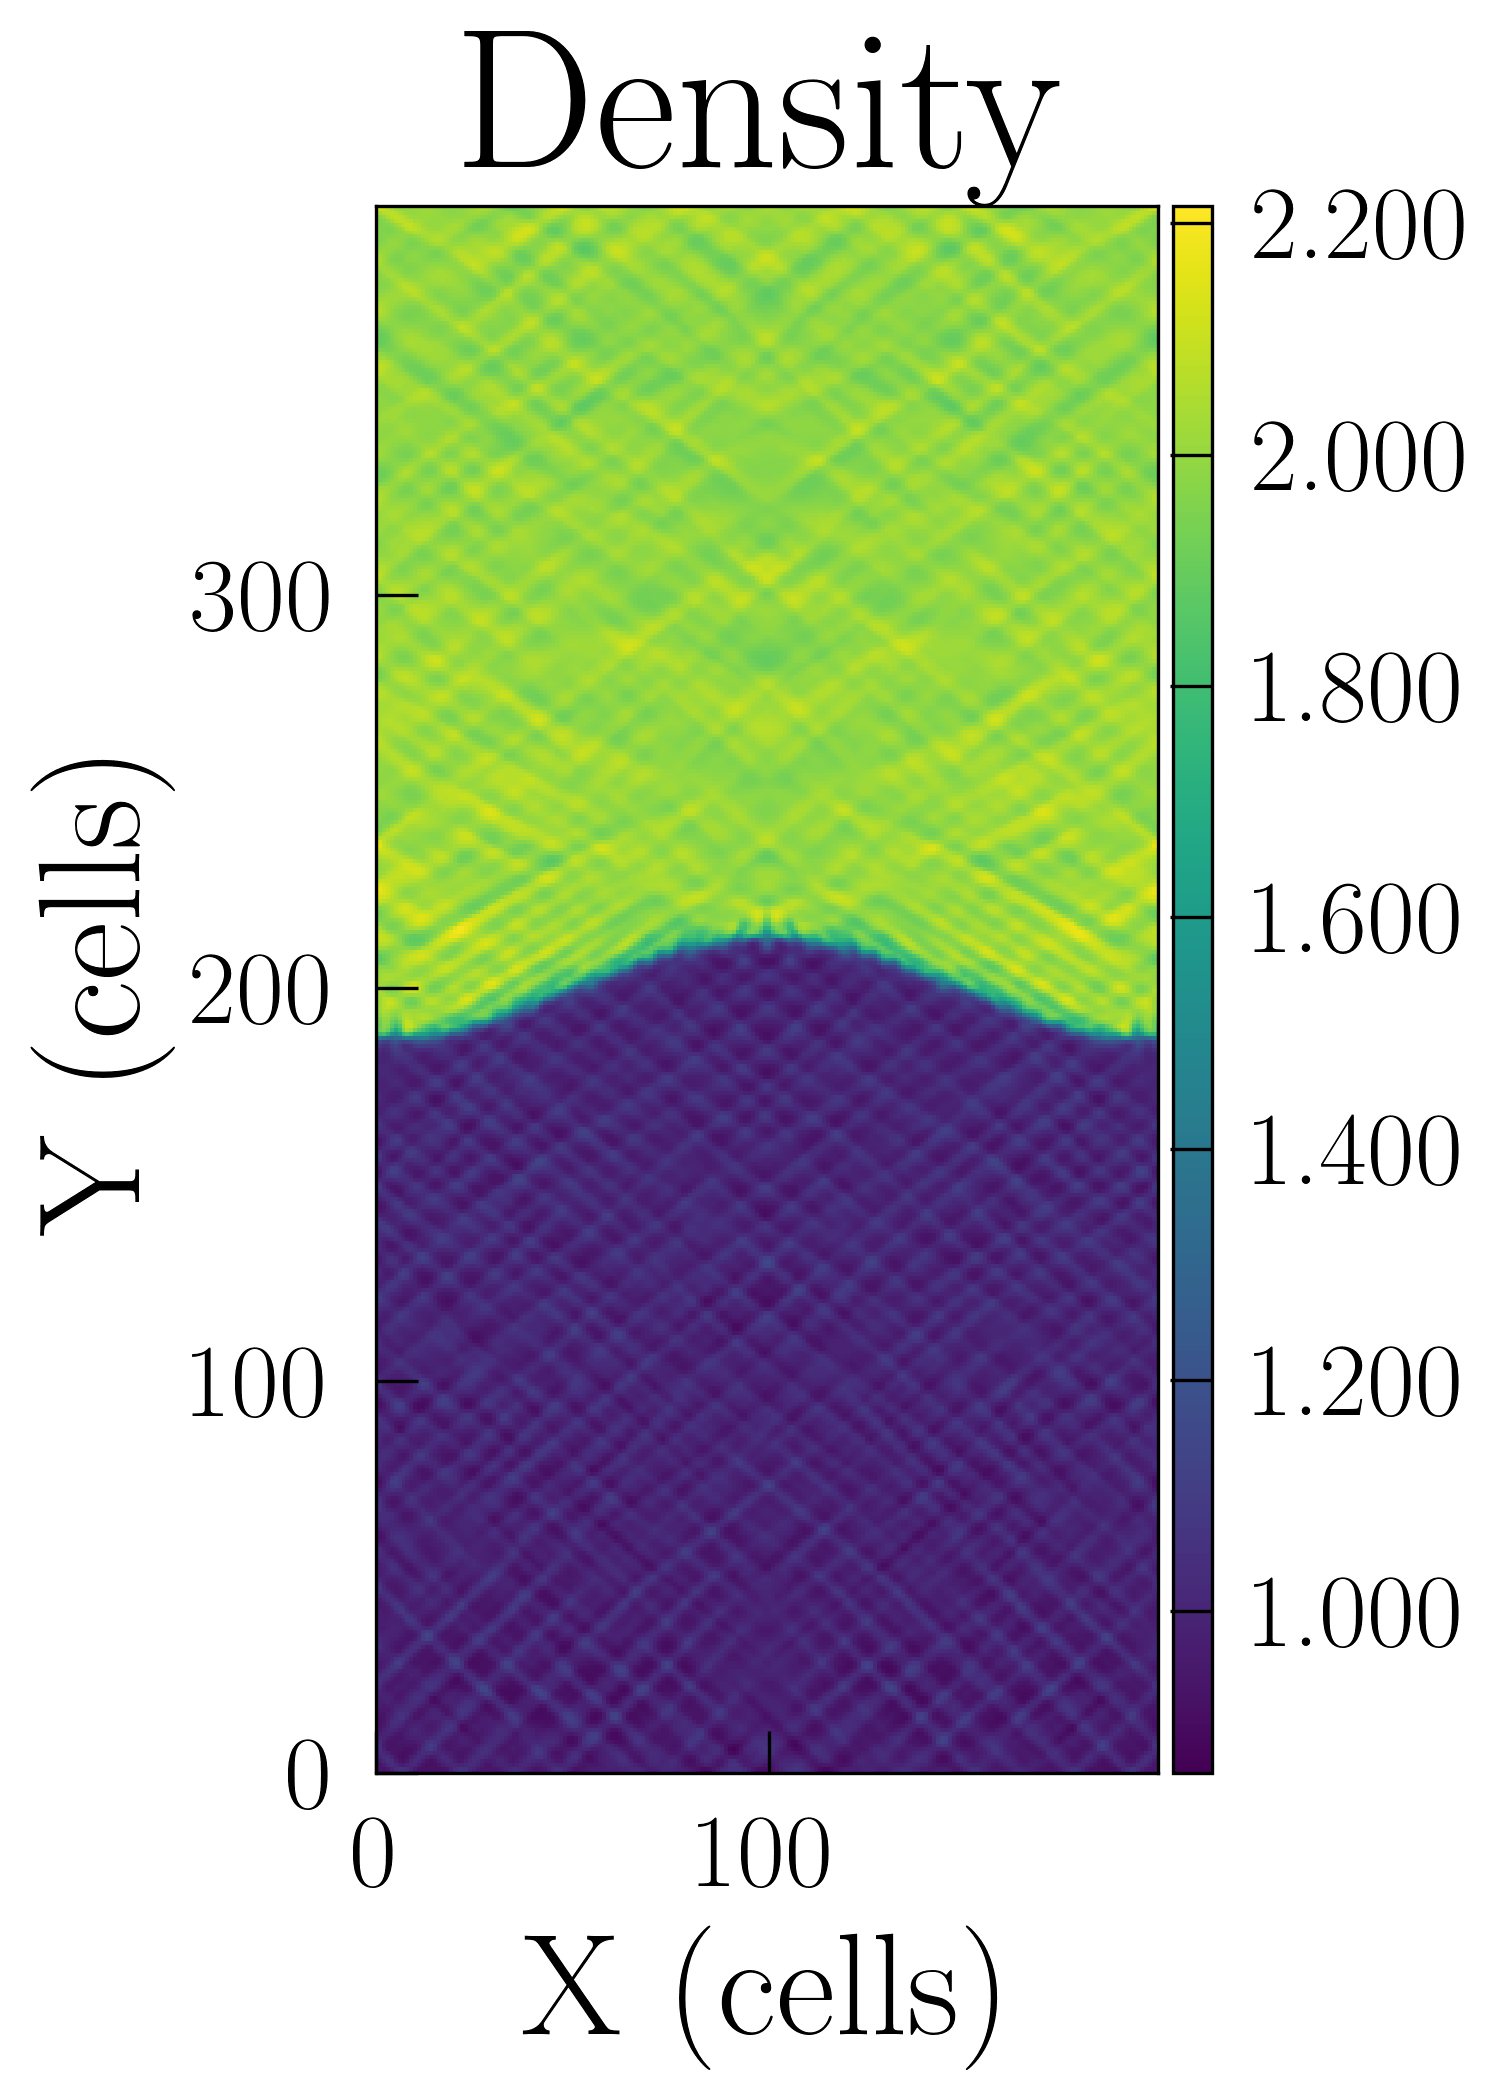

In [81]:
plt_kwargs = {"show": True, "save": False}

plot_density_2D(ch_snap.data, ch_snap.head, plt_kwargs)

In [82]:
plt_kwargs = {"show": False, "save": True}
imgfbase = "img"

cholla_calcs = [velocity_calc, press_calc]

ch_run.make_movie(plot_pressure_2D, keys, imgfbase, imgftype='png', 
               movie_nsnaps=None, valuecalcs=cholla_calcs, plt_kwargs = plt_kwargs)